# Overview

We create a computational framework to implement Newton's method for finding roots of polynomials. For the most basic, one variable, case this looks like

$$
x_{n + 1} = x_n - \frac{f(x_n)}{f'(x_n)}. 
$$

This algorithm finds the roots of a univariate function. We want to expand this method to solve _systems_ of equations. This is done by 

$$
\mathbf{x}_{n+1} = \mathbf{x_n} - J_F(\mathbf{x}_n)^{-1} F(\mathbf{x}_n)
$$

or, for sake of computation, we simply solve 

$$
J_F(\mathbf{x_n})(\mathbf{x}_{n+1} - \mathbf{x}_n) = -F(\mathbf{x}_n)
$$

for the quantity $\mathbf{x}_{n+1} - \mathbf{x}_n$ so that we do not have to compute the inverse of the Jacobian. We will write a function to carry out the algorithm outlined above and will explore several examples using the function we wrote. All computation will be done in `Julia` with the packages found below

In [1]:
using ForwardDiff, LinearAlgebra
using Plots, ImplicitPlots
using LaTeXStrings

## Solving Systems of Equations Using Newton Method
We now create a function to solve a system of equations using the Newton method and the same princeples as above. That is, given a system of equations we find a solution by using the recurisive formula given above, i.e.

$$
    J_F(\mathbf{x_n})(\mathbf{x}_{n+1} - \mathbf{x}_n) = -F(\mathbf{x}_n)
$$

and solve for $\mathbf{x}_{n+1} - \mathbf{x}_n$. We then extract the value for $\mathbf{x}_{n + 1}$ and repeat the process until a particular tolerance is reached. This process is carried out in the following function: 

In [207]:
function newton_solve(start::Vector, Func::Function, tolerance::Float64 = 1.0e-15)

    #evaluate initial point
    tol = Func(start...)

    #check if initial point is solution
    not_minimized = true
    if tol == zeros(length(tol))
        not_minimized = false
    end

    #save steps taken by algorithm
    steps_x = [start[1]]
    steps_y = [start[2]]
    
    i = 0
    while (not_minimized && i < 501)
        #test for convergence 
        if i == 500
            error("Algorithm did not converge!")
        end

        #solve linear system
        J = ForwardDiff.jacobian(x->Func(x...), start)
        start_new = J \ -Func(start...)

        #update values
        for i in 1:length(start)
            start[i] = start_new[i] + start[i]
        end
        tol = Func(start...)

        #test if tolerance is reached
        not_minimized = false
        for i in 1:length(tol)
            if abs(tol[i]) > tolerance
                not_minimized = true
            end
        end

        #append steps taken in first two variables 
        append!(steps_x, start[1])
        append!(steps_y, start[2])
        i += 1
    end

    return start, steps_x, steps_y
end

newton_solve (generic function with 3 methods)

We then verify our solution by considering the case of minimizing the function 

$$
    f : (x, y) \mapsto 2x^4 + y^4 + 2xy^2 - x^2 - \frac{1}{3}y^2 + 10. 
$$

In order to do this, we take the gradient of the above and then use `newton_solve` to find the minimum. We note that the gradient is given by 

$$
    \nabla (x, y) = (8x^3 + 2y^2 - 2x, 4y^3 + 4xy - \frac{2}{3}y). 
$$

We start from the point $ p = (2, 2)$ and commence the algorithm. 

In [3]:
f(x, y) = [8*x^3 + 2*y^2 - 2*x, 4*y^3 + 4*x*y - (2/3)*y]
p = [2.0, 2.0]
p_sol, steps_x, steps_y = newton_solve(p, f)
p_sol

2-element Vector{Float64}:
 0.5
 1.9510543672165753e-19

To show this is indeed a solution, we plug in our above solution and see that we get zero. We also plot to get a visualizating that this indeed works. 

In [4]:
f(p_sol...)

2-element Vector{Float64}:
 0.0
 2.601405822955434e-19

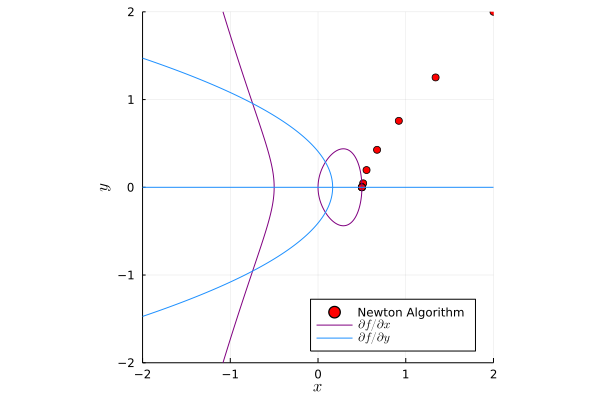

In [5]:
f_surf1(x, y) = 8*x^3 + 2*y^2 - 2*x
f_surf2(x, y) = 4*y^3 + 4*x*y - (2/3)*y
scatter(steps_x, steps_y, color = "red", label = "Newton Algorithm", xlabel = L"x", ylabel = L"y", legend=:bottomright)
implicit_plot!(f_surf1; xlims=(-2,2), ylims=(-2,2), label = L"\partial f / \partial x", line = (:purple))
implicit_plot!(f_surf2; xlims=(-2,2), ylims=(-2,2), label = L"\partial f / \partial y")

## Finding the closest point to the statistical independence model using Newton Method

We implement our above algorithm by considering the statistical independence model with defining equations

$$
\begin{split}
x_1 + x_2 + x_3 + x_4 & = 1 \\
x_1 x_4 - x_2 x_3 = 0
\end{split}
$$

To find the closest points to the curve defined by these equations, we minimize the distance formula using lagrange multipliers, that is, we solve the system of equations given by 

$$
\begin{split}
x_1 + x_2 + x_3 + x_4 & = 1 \\
x_1 x_4 - x_2 x_3 & = 0 \\
2(x_1 - 1) & = \lambda_1 + \lambda_2 x_4 \\
2(x_2 - 5) & = \lambda_1 - \lambda_2 x_3 \\
2(x_3 - 2) & = \lambda_1 - \lambda_2 x_2 \\
2(x_4 - 3) & = \lambda_1 + \lambda_2 x_1
\end{split}
$$

where we have used the point $p = (1, 5, 2, 3) \in \mathbb{R}^4$. This can be done easily using `newton_solve` as follows

In [16]:
f(x1, x2, x3, x4, λ1, λ2) = 
    [x1 + x2 + x3 + x4 - 1, 
    x1*x4 - x2*x3, 
    2*(x1 - 1) - λ1 - λ2*x4, 
    2*(x2 - 5) - λ1 + λ2*x3, 
    2*(x3 - 2) - λ1 + λ2*x2, 
    2*(x4 - 3) - λ1 - λ2*x1]
p = randn(6)
p_sol, steps_x, steps_y = newton_solve(p, f)
p_sol

6-element Vector{Float64}:
 -1.6019431755432922
  2.412543396773429
 -0.3743000249732863
  0.5636998037431494
 -5.117655226373716
 -0.1529734872005719

To verify this is a solution, we plug into the above system and find that we get zero

In [7]:
f(p_sol...)

6-element Vector{Float64}:
  0.0
  0.0
  2.498001805406602e-16
  1.3877787807814457e-16
 -5.551115123125783e-17
  9.159339953157541e-16

## Finding a point on a curve using Newton Method

We now find a point on the following curve using Newton 

$$
(x, y) \mapsto (x^4 + y^4 - 1)(x^2 + y^2 - 2) + x^5y. 
$$

It turns out that simply starting from a point and applying `newton_solve` works in finding a point on the surface even in the underdetermined case. This is a result of the `\` operator automatically finding the norm of the underdetermined system created by taking the Jacobian of our function, i.e. `\` automatically solves the system 

$$
Jx = f(p)
$$

for the minimum $x$. This process is shown below

In [8]:
f(x, y) = [(x^4 + y^4 - 1) * (x^2 + y^2 - 2) + (x^5) * y]
p = [6.0, 6.0]
p_sol, steps_x, steps_y = newton_solve(p, f)
p_sol

2-element Vector{Float64}:
 0.7143919259772923
 1.087335033742158

We then plot the steps taken by the algorithm and plot the surface to visually see what our algorithm is doing.

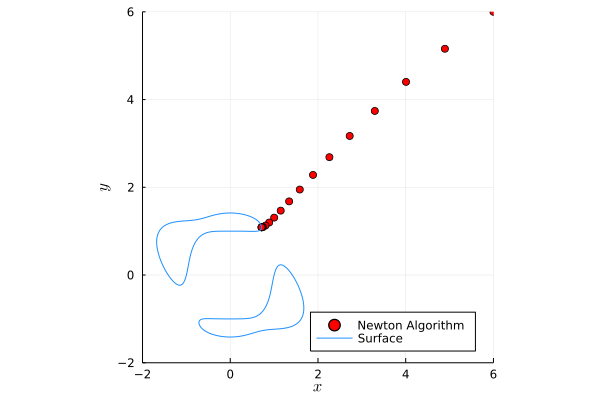

In [9]:
f_surf3(x, y) = (x^4 + y^4 - 1) * (x^2 + y^2 - 2) + (x^5) * y
scatter(steps_x, steps_y, color = "red", label = "Newton Algorithm", legend=:bottomright, 
            xlabel = L"x", ylabel = L"y")
implicit_plot!(f_surf3; xlims=(-2,6), ylims=(-2,6), label = "Surface")

Finally, we make sure our point lies on the curve by

In [10]:
f(p_sol...)

1-element Vector{Float64}:
 6.106226635438361e-16

## Cases of non-convergence

Consider a system of equations that does _not_ converge such as 

$$
f : (x, y) \mapsto (x^2 + y^2 - 1, xy - 5)
$$

This can be visualized with the following plot:

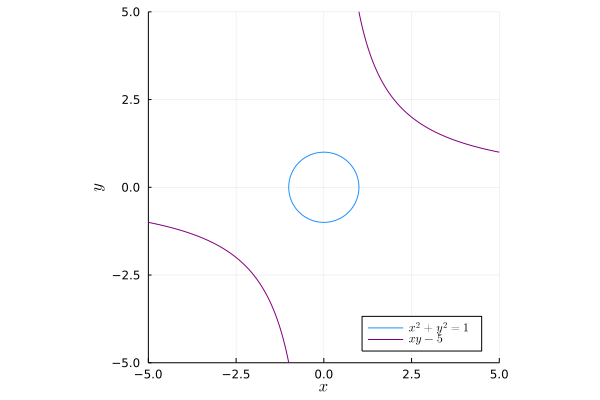

In [11]:
circle(x, y) = x^2 + y^2 - 1
hyperbola(x, y) = x*y - 5
implicit_plot(circle; xlims = (-5, 5), ylims = (-5, 5), label = L"x^2 + y^2 = 1", legend=:bottomright, xlabel = L"x", ylabel = L"y")
implicit_plot!(hyperbola; xlims = (-5, 5), ylims = (-5, 5), label = L"xy - 5", line = (:purple))

If we apply `newton_solve` to this system this clearly throws an error as shown below

In [12]:
f(x, y) = [x * y - 5, x^2 + y^2 - 1]
p = randn(2)
newton_solve(p, f)

LoadError: Algorithm did not converge!

Note that this error is something we wrote into our function when convergence does not occur, i.e. when the number of steps taken is greater than 500. To fix this problem we could consider moving to the complex numbers, however, `ForwardDiff` does not support complex numbers, thus we would need to use a different function to find the gradient. 

For a visualization of what's going on, we plot the first ten points computed by `newton_solve` and plot them below. 

In [222]:
f(x, y) = [x * y - 5, x^2 + y^2 - 1]
p = [-1.0, 3.0]
p_sol, steps_x, steps_y = newton_solve(p, f)
p_sol

2-element Vector{Float64}:
  5.25963298444844
 -1.94300819409304

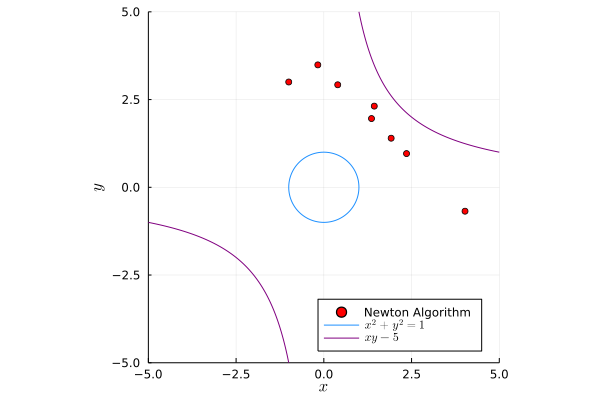

In [230]:
scatter(steps_x, steps_y, color = "red", label = "Newton Algorithm")
implicit_plot!(circle; xlims = (-5, 5), ylims = (-5, 5), label = L"x^2 + y^2 = 1", legend=:bottomright, xlabel = L"x", ylabel = L"y")
implicit_plot!(hyperbola; xlims = (-5, 5), ylims = (-5, 5), label = L"xy - 5", line = (:purple))

   From this we can clearly see that the algorithm will not converge and will rather eventually step off into infinity. 

   # Conclusions

   The above examples illustrate how we can use the Newton-Ralphson method to find solutions to systems of multivariate equations. This method clearly has flaws. Consider our first example in section 1.1. We can see from the picture created that there should be a total of _six_ solutions. We could find all of these by changing our starting point, but this becomes tedius and, for higher dimensional objects, may not be possible. Clearly a better method is needed in finding solutions, or our algorithm must be improved. 

   Despite these obvious problems, Newton's method is incredibly fast and the algorithm, when convergence is possible, converges very quickly. Other methods that are more powerful, such as `Homotopy Continuation`, can take a very long time to run. Thus, we conclude that while Newton is a very powerful tool, other methods are needed to more fully explore systems of equations. 